Using device: cuda
Epoch 1/10, Train Loss: 290.4953, Val Loss: 270.6421
Epoch 2/10, Train Loss: 266.9692, Val Loss: 267.7308
Epoch 3/10, Train Loss: 263.9560, Val Loss: 263.9984
Epoch 4/10, Train Loss: 261.9310, Val Loss: 262.8965
Epoch 5/10, Train Loss: 260.9034, Val Loss: 262.3215
Epoch 6/10, Train Loss: 259.8601, Val Loss: 260.8788
Epoch 7/10, Train Loss: 259.2980, Val Loss: 261.0498
Epoch 8/10, Train Loss: 258.6463, Val Loss: 259.8946
Epoch 9/10, Train Loss: 258.0759, Val Loss: 259.9277
Epoch 10/10, Train Loss: 257.5268, Val Loss: 259.0606


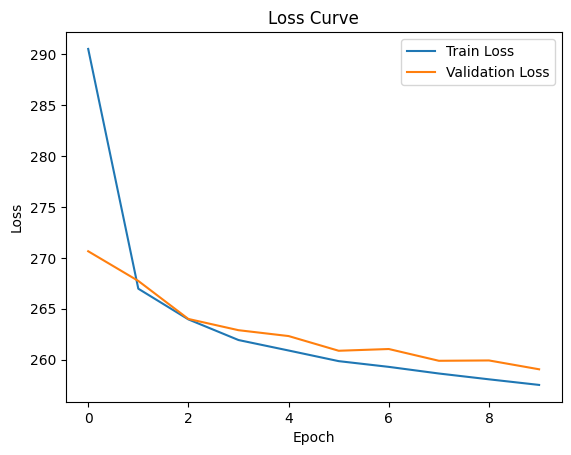

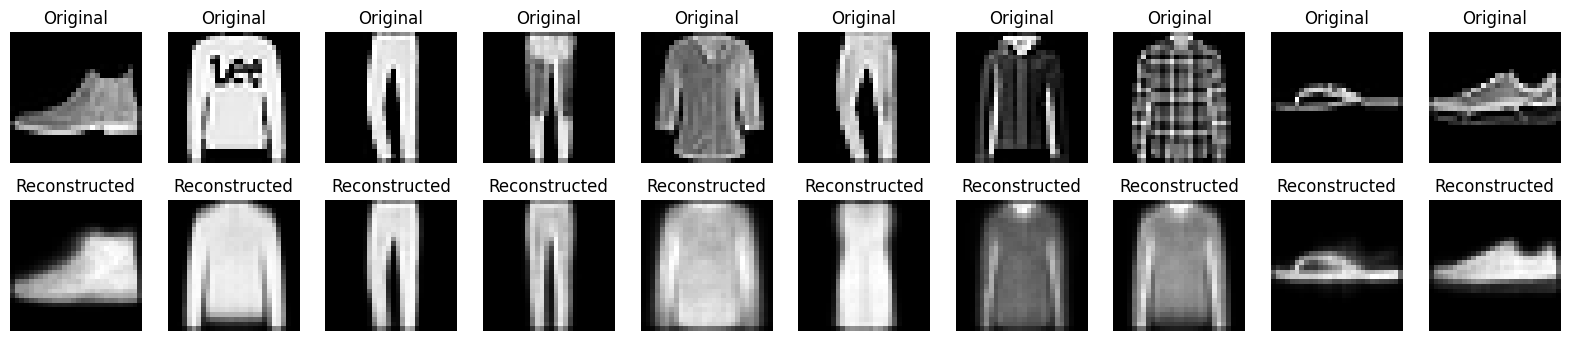

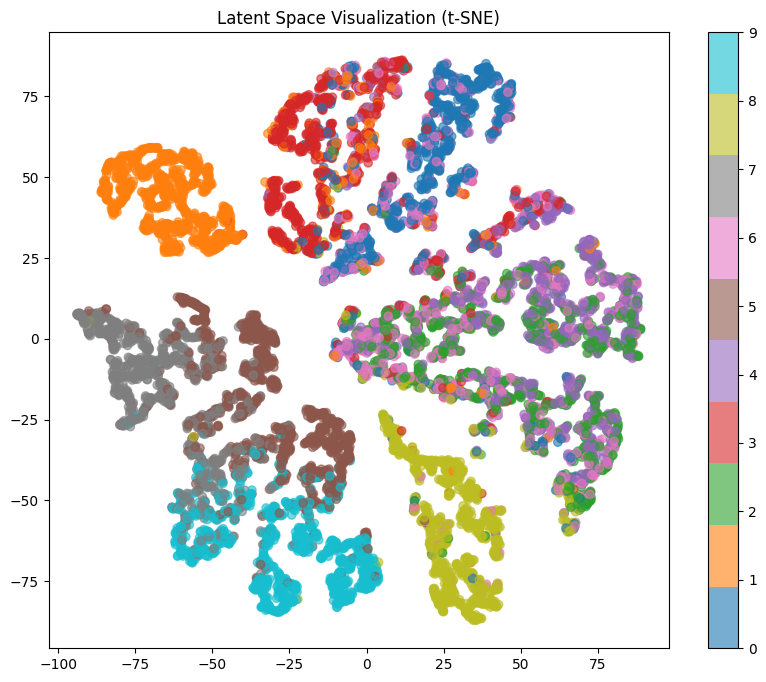

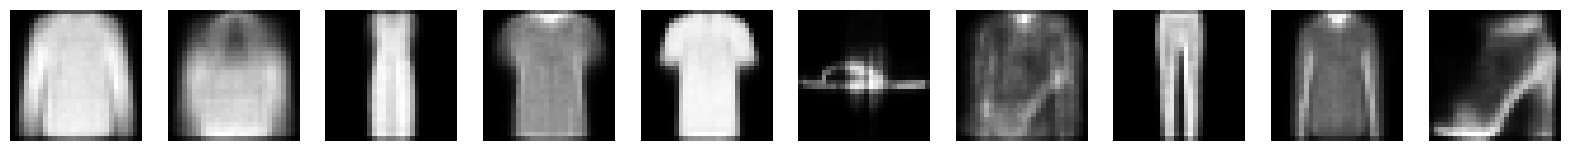

In [2]:
# Install required libraries (only needed for local environments)
# !pip install torch torchvision matplotlib scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
latent_dim = 2
batch_size = 128
learning_rate = 1e-3
epochs = 10  # Reduced for Colab execution speed

# Load Fashion MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model, optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device).view(-1, 28 * 28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device).view(-1, 28 * 28)
            recon_batch, mu, logvar = model(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot Loss Curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Reconstruct Test Images
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    recon_images, _, _ = model(test_images.view(-1, 28 * 28))

# Plot Original vs Reconstructed Images
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original Images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed Images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

plot_images(test_images, recon_images)

# Latent Space Visualization
def visualize_latent_space(model, data_loader, device):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device).view(-1, 28 * 28)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu())
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Use t-SNE for 2D projection
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization (t-SNE)")
    plt.show()

visualize_latent_space(model, test_loader, device)

# Generate New Images
def generate_images(model, latent_dim, device, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated_images = model.decode(z).cpu()
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].view(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

generate_images(model, latent_dim, device)
